In [1]:
import math
import itertools
import numpy as np
from numba import njit

import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import jit
from jax.config import config
config.update("jax_enable_x64", True)

from dags import concatenate_functions
from lcm.dispatchers import gridmap, productmap

from numpy.testing import assert_array_almost_equal as aaae

In [2]:
def plot_runtime(n_points, runtime_numba, runtime_jax, func="product_map"):
    plt.figure(figsize=[10, 6])
    plt.plot(n_points, [i * 1000 for i in runtime_numba], label="Numba")
    plt.plot(n_points, [i * 1000 for i in runtime_jax], label="JAX")

    plt.xlabel("Number of Grid Points")
    plt.ylabel("Runtime (in milliseconds)")
    plt.title(f"Runtime of hardcoded Numba function versus {func} with JAX")
    
    plt.legend()
    plt.show()

## product_map: 2 grids benchmark

### Trivial setup

In [3]:
def _utility(_consumption, _leisure):
    return _consumption + _leisure


def _leisure(working):
    return 24 - working


def _consumption(working, wage):
    return wage * working

### Numba: Dimensions hardcoded

In [4]:
@njit(fastmath=True)
def product_map_numba_2d(wage, working):
    n_wage = wage.shape[0]
    n_working = working.shape[0]

    cross_product = np.empty((n_wage, n_working))

    for i in range(n_wage):
        for j in range(n_working):
            cross_product[i, j] = wage[i] * working[j] + (24 - working[j])

    return cross_product

wage = np.linspace(1, 10, 101)
working = np.linspace(0, 24, 25)
rslt_numba = product_map_numba_2d(wage, working)


### LCM productmap

In [5]:
grids = {
    "wage": jnp.linspace(1, 10, 101),
    "working": jnp.linspace(0, 24, 25),
}

utility_concat = concatenate_functions(
    functions=[_utility, _leisure, _consumption], targets="_utility"
)
_decorated_func = productmap(utility_concat, ["wage", "working"])
decorated_func_jit = jit(_decorated_func)
rslt_jax = decorated_func_jit(**grids)

In [6]:
### Assert equality

aaae(rslt_jax, rslt_numba)

In [7]:
def get_numba_runtime_2d():        
    total_points = []
    runtime = []
    
    for len_grid in grid_space:
        total_points.append(len_grid**2)
        
        grids = {
            "wage": np.linspace(1, 10, len_grid),
            "working": np.linspace(0, 24, len_grid),
        }
        
        product_map_numba_2d(**grids)
            
        timeit_res = %timeit -r 7 -n 1_000 -o product_map_numba_2d(**grids)
        runtime.append(timeit_res.average)

    return total_points, runtime

def get_jax_runtime_2d():
    utility_concat = concatenate_functions(
    functions=[_utility, _leisure, _consumption],
    targets="_utility"
    )
    _decorated_func = productmap(utility_concat, ["wage", "working"])
    decorated_func_jit = jit(_decorated_func)
        
    total_points = []
    runtime = []
    
    for len_grid in grid_space:
        total_points.append(len_grid**2)
        
        grids = {
            "wage": jnp.linspace(1, 10, len_grid),
            "working": jnp.linspace(0, 24, len_grid),
        }
    
        decorated_func_jit(**grids)
        
        timeit_res = %timeit -r 7 -n 1_000 -o decorated_func_jit(**grids).block_until_ready()
        runtime.append(timeit_res.average)

    return total_points, runtime

grid_space = [10, 25, 50] + np.arange(100, 1100, 100).tolist()

In [8]:
n_points_2_grids, runtime_numba_2d = get_numba_runtime_2d()

1.4 µs ± 278 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.18 µs ± 216 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.52 µs ± 95.1 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.09 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
14.2 µs ± 852 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
26.4 µs ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
46.9 µs ± 4.83 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
70.9 µs ± 5.92 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
96.4 µs ± 3.99 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
133 µs ± 3.59 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
191 µs ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
281 µs ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
423 µs ± 23.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
_, runtime_jax_2d = get_jax_runtime_2d()

5.71 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
5.38 µs ± 155 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
5.96 µs ± 402 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
10 µs ± 1.36 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
19.1 µs ± 704 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
35.1 µs ± 4.22 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
49.2 µs ± 3.94 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
63.3 µs ± 2.83 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
83.1 µs ± 8.34 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
103 µs ± 12.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
126 µs ± 6.04 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
177 µs ± 13.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
284 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


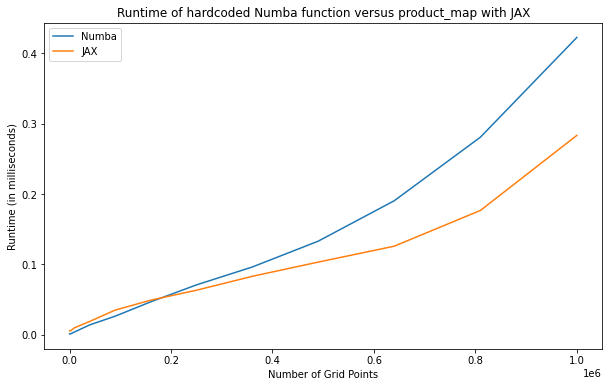

In [10]:
plot_runtime(n_points_2_grids, runtime_numba_2d, runtime_jax_2d)

## *product_map*: 4 grids benchmark, more complex computations

In [11]:
def _utility_4d(_consumption_4d, _leisure_4d):
    return _consumption_4d + _leisure_4d


def _leisure_4d(d):
    return jnp.cos(d)


def _consumption_4d(a, b, c):
    return jnp.log(a) + jnp.sqrt(jnp.square(b) * c)


@njit(fastmath=True)
def product_map_numba_4d(a, b, c, d):
    n_a = a.shape[0]
    n_b = b.shape[0]
    n_c = c.shape[0]
    n_d = d.shape[0]

    cross_product = np.empty((n_a, n_b, n_c, n_d))

    for i in range(n_a):
        for j in range(n_b):
            for k in range(n_c):
                for l in range(n_d):
                    cross_product[i, j, k, l] = (
                        np.log(a[i]) + np.sqrt(b[j] ** 2 * c[k]) + np.cos(d[l])
                    )

    return cross_product

In [12]:
grids = {
    "a": jnp.linspace(1, 10, 101),
    "b": jnp.linspace(0, 24, 25),
    "c": jnp.linspace(1, 5, 5),
    "d": jnp.linspace(-7, 2, 10)
}

a = np.linspace(1, 10, 101)
b = np.linspace(0, 24, 25)
c = np.linspace(1, 5, 5)
d = np.linspace(-7, 2, 10)

utility_concat_4d = concatenate_functions(
    functions=[_utility_4d, _leisure_4d, _consumption_4d,],
    targets="_utility_4d"
)
    
_decorated_func = productmap(utility_concat_4d , ["a", "b", "c", "d"])
decorated_func_jit = jit(_decorated_func)  
rslt_jax = decorated_func_jit(**grids)

rslt_numba = product_map_numba_4d(a, b, c, d)

aaae(rslt_jax, rslt_numba)

In [13]:
def get_numba_runtime_4d(len_grids_arr):
    total_points = []
    runtime = []
    
    for len_grids in len_grids_arr.T:
        len_a, len_b, len_c, len_d = len_grids.astype(int)
        total_points.append(math.prod(len_grids))
        
        a = np.linspace(1, 10, len_a)
        b = np.linspace(0, 24, len_b)
        c = np.linspace(1, 5, len_c)
        d = np.linspace(-7, 2, len_d)
    
        product_map_numba_4d(a, b, c, d)
        
        timeit_res = %timeit -r 7 -n 1_000 -o product_map_numba_4d(a, b, c, d)
        runtime.append(timeit_res.average)

    return total_points, runtime


def get_jax_runtime_4d(len_grids_arr):
    utility_concat_4d = concatenate_functions(
    functions=[_utility_4d, _leisure_4d, _consumption_4d,],
    targets="_utility_4d"
    )
    
    _decorated_func = productmap(utility_concat_4d , ["a", "b", "c", "d"])
    decorated_func_jit = jit(_decorated_func)    
    
    total_points = []
    runtime = []
    
    for len_grids in len_grids_arr.T:
        len_a, len_b, len_c, len_d = len_grids.astype(int)
        total_points.append(math.prod(len_grids))
        
        grids = {
            "a": jnp.linspace(1, 10, len_a),
            "b": jnp.linspace(0, 24, len_b),
            "c": jnp.linspace(1, 5, len_c),
            "d": jnp.linspace(-7, 2, len_d)
        }
    
        decorated_func_jit(**grids)
        
        timeit_res = %timeit -r 7 -n 1_000 -o decorated_func_jit(**grids).block_until_ready()
        runtime.append(timeit_res.average)

    return total_points, runtime

len_grids_arr = np.vstack((
    [5, 10, 20, 60, 100],
    np.linspace(5, 25, 5),
    np.linspace(1, 5, 5),
    np.linspace(2, 10, 5),
))

In [14]:
n_points_4d, runtime_numba_4d = get_numba_runtime_4d(len_grids_arr)

3.43 µs ± 815 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
23.4 µs ± 5.48 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
113 µs ± 6.93 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
785 µs ± 25.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.6 ms ± 44.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
_, runtime_jax_4d = get_jax_runtime_4d(len_grids_arr)

9.46 µs ± 1.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
6.29 µs ± 332 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
9.13 µs ± 638 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
17.6 µs ± 923 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
59.9 µs ± 7.15 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


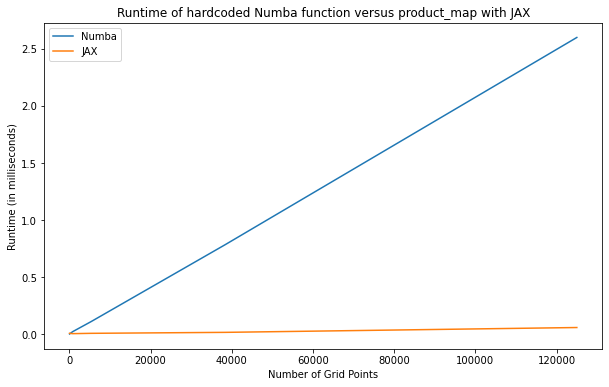

In [16]:
plot_runtime(n_points_4d, runtime_numba_4d, runtime_jax_4d)

## *gridmap*: 4 grids benchmark

In [17]:
@njit(fastmath=True)
def state_space_map_numba(a, b, c, d):
    n_a = a.shape[0]
    n_b = b.shape[0]
    n_c = c.shape[0]

    state_space_product = np.empty((n_a, n_b, n_c))

    for i in range(n_a):
        for j in range(n_b):
            for k in range(n_c):
                state_space_product[i, j, k] = (
                    np.log(a[i]) + np.sqrt(b[j] ** 2 * c[k]) + np.cos(d[k])
                )

    return state_space_product

In [18]:
# JAX
dense_variables = {
    "a": jnp.linspace(1, 10, 101),
    "b": jnp.linspace(0, 24, 25),
}
combined_grids = {
    "c": jnp.linspace(1, 5, 5),
    "d": jnp.linspace(-7, 2, 10)
}
helper = jnp.array(list(itertools.product(*combined_grids.values()))).T

contingent_variables = {
    "c": helper[0],
    "d": helper[1],
}

# Numpy
dense_variables_numpy = {
    "a": np.linspace(1, 10, 101),
    "b": np.linspace(0, 24, 25),
}
combined_grids_numpy = {
    "c": np.linspace(1, 5, 5),
    "d": np.linspace(-7, 2, 10)
}
helper = np.array(list(itertools.product(*combined_grids_numpy.values()))).T

contingent_variables_numpy = {
    "c": helper[0],
    "d": helper[1],
}
all_grids = {**dense_variables_numpy, **contingent_variables_numpy}

In [19]:
utility_concat_4d = concatenate_functions(
    functions=[
        _utility_4d,
        _leisure_4d,
        _consumption_4d,
    ],
    targets="_utility_4d",
)

_decorated_func = gridmap(
    utility_concat_4d, list(dense_variables), list(contingent_variables)
)
decorated_func_jit = jit(_decorated_func)
rslt_jax = decorated_func_jit(**dense_variables, **contingent_variables)

rslt_numba = state_space_map_numba(*all_grids.values())

aaae(rslt_jax, rslt_numba)

In [20]:
def get_numba_runtime(len_grids_arr):
    total_points = []
    runtime = []
    
    for len_grids in len_grids_arr.T:
        len_a, len_b, len_c, len_d = len_grids.astype(int)
        total_points.append(math.prod(len_grids))
        
        dense_variables = {
            "a": np.linspace(1, 10, len_a),
            "b": np.linspace(0, 24, len_b),
        }
        complex_grids = {
            "c": np.linspace(1, 5, len_c),
            "d": np.linspace(-7, 2, len_d)
        }
        helper = np.array(list(itertools.product(*complex_grids.values()))).T

        complex_variables = {
            "c": helper[0],
            "d": helper[1],
        }
        all_grids = {**dense_variables, **complex_variables}
    
        state_space_map_numba(*all_grids.values())
        
        timeit_res = %timeit -r 7 -n 1_000 -o state_space_map_numba(*all_grids.values())
        runtime.append(timeit_res.average)

    return total_points, runtime


def get_jax_runtime(len_grids_arr):
    utility_concat_4d = concatenate_functions(
    functions=[_utility_4d, _leisure_4d, _consumption_4d],
    targets="_utility_4d"
    )
    
    _decorated_func = gridmap(utility_concat_4d , ["a", "b"], ["c", "d"])
    decorated_func_jit = jit(_decorated_func)    
    
    total_points = []
    runtime = []
    
    for len_grids in len_grids_arr.T:
        len_a, len_b, len_c, len_d = len_grids.astype(int)
        total_points.append(math.prod(len_grids))
        
        dense_variables = {
            "a": jnp.linspace(1, 10, len_a),
            "b": jnp.linspace(0, 24, len_b),
        }
        complex_grids = {
            "c": jnp.linspace(1, 5, len_c),
            "d": jnp.linspace(-7, 2, len_d)
        }
        helper = jnp.array(list(itertools.product(*complex_grids.values()))).T

        complex_variables = {
            "c": helper[0],
            "d": helper[1],
        }
    
        decorated_func_jit(**dense_variables, **complex_variables)
        
        timeit_res = %timeit -r 7 -n 1_000 -o decorated_func_jit(**dense_variables, **complex_variables).block_until_ready()
        runtime.append(timeit_res.average)

    return total_points, runtime

In [21]:
n_points, runtime_numba = get_numba_runtime(len_grids_arr)

2.68 µs ± 284 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
19.8 µs ± 714 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
116 µs ± 8.63 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
793 µs ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.55 ms ± 54.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
_, runtime_jax = get_jax_runtime(len_grids_arr)

6.6 µs ± 392 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
6.51 µs ± 372 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
8.19 µs ± 558 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
24.6 µs ± 1.84 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
49.3 µs ± 4.72 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


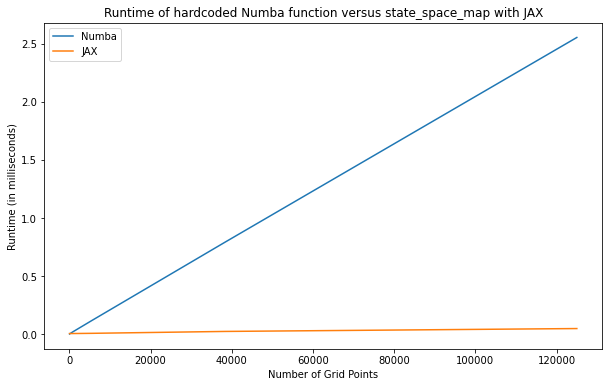

In [23]:
plot_runtime(n_points, runtime_numba, runtime_jax, func="state_space_map")

## 4d Benchmark with multiple targets and product_map

In [24]:
def _utility_4d(_consumption_4d, _leisure_4d):
    return _consumption_4d + _leisure_4d


def _leisure_4d(d):
    return jnp.cos(d)


def _consumption_4d(a, b, c):
    return jnp.log(a) + jnp.sqrt(jnp.square(b) * c)


@njit(fastmath=True)
def product_map_numba_4d(a, b, c, d):
    n_a = a.shape[0]
    n_b = b.shape[0]
    n_c = c.shape[0]
    n_d = d.shape[0]

    out_utility = np.empty((n_a, n_b, n_c, n_d))
    out_leisure = np.empty((n_a, n_b, n_c, n_d))
    
    for i in range(n_a):
        for j in range(n_b):
            for k in range(n_c):
                for l in range(n_d):
                    _leis = np.cos(d[l])
                    
                    out_leisure[i, j, k, l] = _leis
                    out_utility[i, j, k, l] = (
                        np.log(a[i]) + np.sqrt(b[j] ** 2 * c[k]) + _leis
                    )

    return out_leisure, out_utility

In [25]:
grids = {
    "a": jnp.linspace(1, 10, 101),
    "b": jnp.linspace(0, 24, 25),
    "c": jnp.linspace(1, 5, 5),
    "d": jnp.linspace(-7, 2, 10)
}

a = np.linspace(1, 10, 101)
b = np.linspace(0, 24, 25)
c = np.linspace(1, 5, 5)
d = np.linspace(-7, 2, 10)

utility_concat_4d = concatenate_functions(
    functions=[_utility_4d, _leisure_4d, _consumption_4d],
    targets=["_leisure_4d", "_utility_4d"]
)
    
_decorated_func = productmap(utility_concat_4d , ["a", "b", "c", "d"])
decorated_func_jit = jit(_decorated_func)  
rslt_jax = decorated_func_jit(**grids)

rslt_numba = product_map_numba_4d(a, b, c, d)

aaae(rslt_jax, rslt_numba)

In [26]:
def get_numba_runtime_4d(len_grids_arr):
    total_points = []
    runtime = []
    
    for len_grids in len_grids_arr.T:
        len_a, len_b, len_c, len_d = len_grids.astype(int)
        total_points.append(math.prod(len_grids))
        
        a = np.linspace(1, 10, len_a)
        b = np.linspace(0, 24, len_b)
        c = np.linspace(1, 5, len_c)
        d = np.linspace(-7, 2, len_d)
    
        product_map_numba_4d(a, b, c, d)
        
        timeit_res = %timeit -r 7 -n 1_000 -o product_map_numba_4d(a, b, c, d)
        runtime.append(timeit_res.average)

    return total_points, runtime


def get_jax_runtime_4d(len_grids_arr):
    utility_concat_4d = concatenate_functions(
    functions=[_utility_4d, _leisure_4d, _consumption_4d],
    targets="_utility_4d"
    )
    
    _decorated_func = productmap(utility_concat_4d , ["a", "b", "c", "d"])
    decorated_func_jit = jit(_decorated_func)    
    
    total_points = []
    runtime = []
    
    for len_grids in len_grids_arr.T:
        len_a, len_b, len_c, len_d = len_grids.astype(int)
        total_points.append(math.prod(len_grids))
        
        grids = {
            "a": jnp.linspace(1, 10, len_a),
            "b": jnp.linspace(0, 24, len_b),
            "c": jnp.linspace(1, 5, len_c),
            "d": jnp.linspace(-7, 2, len_d)
        }
    
        decorated_func_jit(**grids)
        
        timeit_res = %timeit -r 7 -n 1_000 -o decorated_func_jit(**grids).block_until_ready()
        runtime.append(timeit_res.average)

    return total_points, runtime

len_grids_arr = np.vstack((
    [5, 10, 20, 60, 100],
    np.linspace(5, 25, 5),
    np.linspace(1, 5, 5),
    np.linspace(2, 10, 5),
))

In [27]:
n_points_4d, runtime_numba_4d = get_numba_runtime_4d(len_grids_arr)

2.61 µs ± 183 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
28 µs ± 5.81 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
119 µs ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
817 µs ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.64 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
_, runtime_jax_4d = get_jax_runtime_4d(len_grids_arr)

8.35 µs ± 1.97 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
6.49 µs ± 333 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
8.44 µs ± 553 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
20.1 µs ± 2.42 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
56.1 µs ± 6.56 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


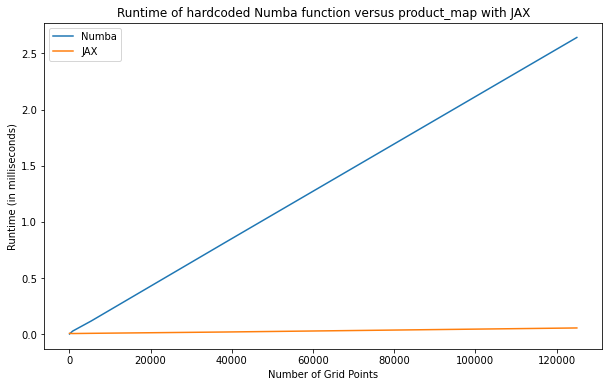

In [29]:
plot_runtime(n_points_4d, runtime_numba_4d, runtime_jax_4d)